In [16]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
stock1 = "BA"
stock2 = "AIR.PA"
data = yf.download([stock1, stock2], start = "2010-01-01")["Close"]
data = data.dropna()

C:\Users\sidva\AppData\Local\Temp\ipykernel_28960\4044230119.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download([stock1, stock2], start = "2010-01-01")["Close"]
[*********************100%***********************]  2 of 2 completed


In [3]:
#Calculating rolling beta
window = 252
hedge_ratio = []
for i in range(window, len(data)):
    y = data[stock1].iloc[i-window:i]
    x = sm.add_constant(data[stock2].iloc[i-window:i])
    model = sm.OLS(y, x).fit()
    hedge_ratio.append(model.params[stock2])
hedge_ratio = pd.Series(hedge_ratio, index = data.index[window:])

#Calculating rolling spread 
spread = data[stock1].iloc[window:] - hedge_ratio.values * data[stock2].iloc[window:]

#Calculating rolling mean and std
spread_mean = spread.rolling(window).mean().shift(1)
spread_std = spread.rolling(window).std().shift(1)
zscore = (spread - spread_mean) / spread_std
print(zscore)

Date
2011-01-05         NaN
2011-01-06         NaN
2011-01-07         NaN
2011-01-10         NaN
2011-01-11         NaN
                ...   
2025-11-03   -1.792120
2025-11-04   -1.785523
2025-11-05   -1.696644
2025-11-06   -1.573953
2025-11-07   -1.526977
Length: 3698, dtype: float64


In [5]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(spread.dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -3.6846147540326695
p-value: 0.0043348401822107105


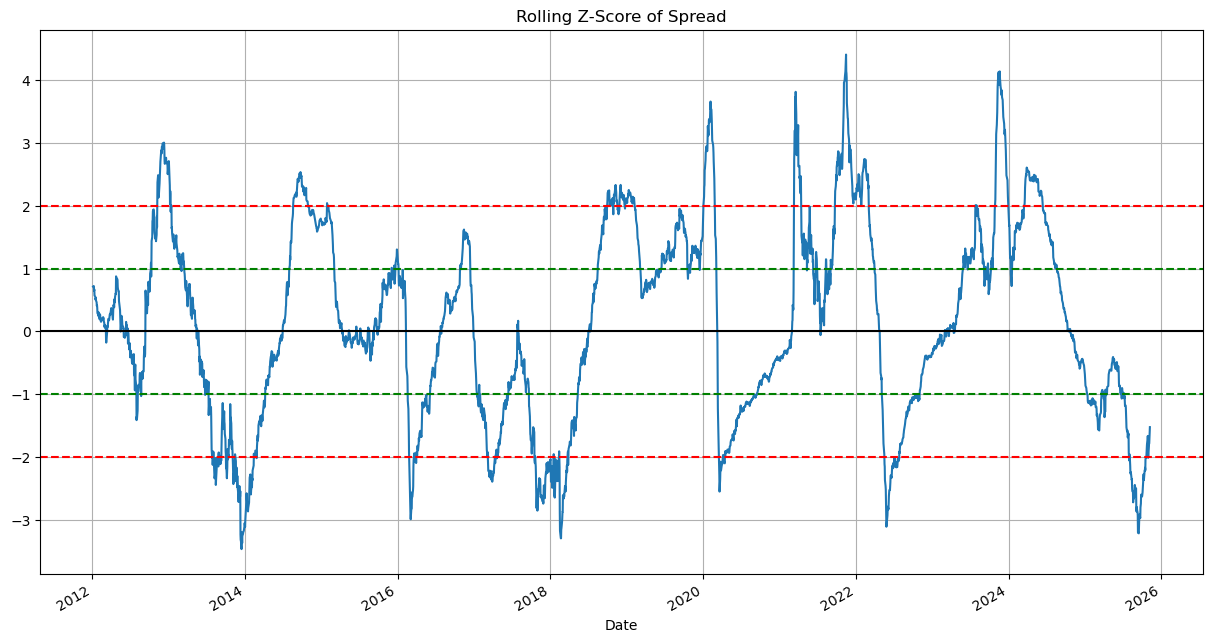

In [4]:
#Plot z-score
zscore.plot(figsize = (15, 8), title = "Rolling Z-Score of Spread")
plt.axhline(0, color = "black", label = "0")
plt.axhline(1, color = "green", linestyle = "--", label = "+1")
plt.axhline(-1, color = "green", linestyle = "--", label = "-1")
plt.axhline(2, color = "red", linestyle = "--", label = "+2")
plt.axhline(-2, color = "red", linestyle = "--", label = "-2")
plt.grid(True)
plt.show()

In [7]:
#Signals
signals = pd.DataFrame({
    "strategy_returns": np.random.normal(0.001, 0.02, 100)})
signals["zscore"] = zscore
signals["long_spread"] = zscore < -1.5
signals["short_spread"] = zscore > 1.5
signals["exit"] = (zscore > -0.25) & (zscore < 0.25)

position = []
current_position = 0

for i in range(len(signals)):
    if signals["long_spread"].iloc[i]:
        current_position = 1
    elif signals["short_spread"].iloc[i]:
        current_position = -1
    elif signals["exit"].iloc[i]:
        current_position = 0
        
    position.append(current_position)
    
signals["position"] = position
signals["position_shifted"] = signals["position"].shift()

In [ ]:
#Calculate and plot returns
returns = data[[stock1, stock2]].pct_change().iloc[window:]
signals["position_shifted"] = signals["position"].shift()
signals["hedge_ratio"] = hedge_ratio
signals["strategy_returns"] = signals["position_shifted"] * (
    returns[stock1] - signals["hedge_ratio"] * returns[stock2])
signals["cumulative_returns"] = (1 + signals["strategy_returns"]).cumprod()
signals["cumulative_returns"].plot(figsize = (15,8), title = "Cumulative Returns")
plt.grid(True)
plt.show()

In [8]:
#Sharpe Ratio Calculation
sharpe_ratio = (
    signals["strategy_returns"].mean()/
    signals["strategy_returns"].std() * np.sqrt(252))
print("Sharpe Ratio:", sharpe_ratio)
print(signals["strategy_returns"].describe())

Sharpe Ratio: 1.5433428203405661
count    100.000000
mean       0.001710
std        0.017589
min       -0.037084
25%       -0.012332
50%        0.003030
75%        0.012392
max        0.039459
Name: strategy_returns, dtype: float64
